Author: Sanjeev Dahal <br>
Script for simulating model iSD1509 to predict gene essentiality

### import all packages

In [ ]:
import pandas as pd
import random
import numpy as np

In [2]:
import cobra
from cobra import Model, Reaction, Metabolite
cobra_config = cobra.Configuration()

from cobra.flux_analysis import gapfill
from cobra.flux_analysis import pfba

In [3]:
from cobra.flux_analysis import flux_variability_analysis

In [4]:
import os
from os.path import join

In [5]:
mydir = os.getcwd()

In [6]:
model_iSD = cobra.io.read_sbml_model(join(mydir, 'iSDModel.xml'))

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-08


In [7]:
# for r in model_iSD.reactions.query('_pphn'):
#     r.bounds = 0., 0.

# storing default boundaries for both models
original_bounds_dict = {}
for r in model_iSD.reactions:
    lb, ub = model_iSD.reactions.get_by_id(r.id).lower_bound, model_iSD.reactions.get_by_id(r.id).upper_bound
    original_bounds_dict[r.id] = [lb, ub]

### does the model grow on LB?

In [8]:
lb_media = pd.read_excel(join(mydir, 'media_LB_SCFM_MM.xlsx'), sheet_name= 'LB', header=0)

In [9]:
# don't need this one as the minimal media components have been added
for met in lb_media.metabolites:
    metrxn = "EX_" + met + "_e"
    if metrxn in model_iSD.reactions:
        model_iSD.reactions.get_by_id(metrxn).bounds = np.float(lb_media[lb_media.loc[:,'metabolites'] == met].lb.values[0]), np.float(lb_media[lb_media.loc[:,'metabolites'] == met].ub.values[0])
#         print(metrxn, "is present in the model")
    else:
        met_e = met + "_e"
        if met_e in [x.id for x in model_iSD.metabolites]:
            model_iSD.add_boundary(model_iSD.metabolites.get_by_id(met_e), type='exchange', lb = np.float(lb_media[lb_media.loc[:,'metabolites'] == met].lb.values[0]), ub = np.float(lb_media[lb_media.loc[:,'metabolites'] == met].ub.values[0]))
#             print(met_e, "is present in the model, but the reaction was not")
        else:
            met_add = Metabolite(id = met_e, compartment='C_e')
            model_iSD.add_metabolites([met_add])
            model_iSD.add_boundary(model_iSD.metabolites.get_by_id(met_e), type='exchange', lb = np.float(lb_media[lb_media.loc[:,'metabolites'] == met].lb.values[0]), ub = np.float(lb_media[lb_media.loc[:,'metabolites'] == met].ub.values[0]))
#             print(met_e, "is not present in the model, so the metabolite was created, and the reaction was addded")

/Users/sanjeevdahal/opt/miniconda3/envs/myCobra/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


### first of all compute the uptake rates using the experimentally determined growth rates

In [12]:
growth_rates = {'o2': 0.825, #hr-1
                'no3': 0.576, #hr-1
               }

#### create function for resetting the model, for constraining the model and for calculation of flux-sum

In [13]:
def reset_model(model, original_bounds):
    for rs in model.reactions:
        model.bounds = original_bounds[rs.id][0], original_bounds[rs.id][1]
    
    return model

In [14]:
def retreive_medium_for_condition(growth_media, terminal_oxidase):
    return_medium = {}
    if terminal_oxidase == 'o2':
        for met in growth_media.metabolites:
            metrxn = "EX_" + met + "_e"
            if met == 'o2':
                return_medium[metrxn] = 1000. #unbounded
            elif met == 'no3' or met == 'no2':
                return_medium[metrxn] = 0. #zero for aerobic reaction
            else:
                return_medium[metrxn] = abs(np.float(lb_media[lb_media.loc[:,'metabolites'] == met].lb.values[0]))
    elif terminal_oxidase == 'no3' or terminal_oxidase == 'no2':
        for met in growth_media.metabolites:
            metrxn = "EX_" + met + "_e"
            if met == 'o2':
                return_medium[metrxn] = 0. #zero for aerobic reaction
            else:
                return_medium[metrxn] = abs(np.float(lb_media[lb_media.loc[:,'metabolites'] == met].lb.values[0]))
            
        return_medium[f'EX_{terminal_oxidase}_e'] = 1000.
    else:
        return ValueError('The terminal oxidase should be either o2, no3 or no2')
    
    
    return return_medium
    

In [15]:
def constrain_model_for_ub9_simulations(model, medium, terminal_oxidase, growth_dictionary=None):
    model_copy = model.copy()
    
    model_copy.medium = medium
    
    if terminal_oxidase == 'o2':
        objective_rxn = 'BIOMASS_PA14_v27M' #aerobic biomass reaction
    elif terminal_oxidase == 'no3' or terminal_oxidase == 'no2':
        objective_rxn = 'BIOMASS_PA14_v27M_ANA' #anaerobic biomass reaction
        
        o2_rxn_list = ['CYTCBB4pp_1', 'CYTCBB4pp_2', 'CYTCBB4pp_3', 'CYTCBB4pp_4', 'CYTCAA6pp', 'CIO3pp_q8', 'CIO3pp_q9', 'CYTBO3_4pp_q8', 'CYTBO3_4pp_q9']
        #shutting down o2 containing reactions
        for rs in o2_rxn_list:
            model_copy.reactions.get_by_id(rs).bounds = 0., 0.
    
    else:
        return ValueError('The terminal oxidase should be either o2, no3 or no2')
    
    #constrain the growth rate or not
    if growth_dictionary == None:
        model_copy.reactions.get_by_id(objective_rxn).bounds = 0., 1000.
    else:
        model_copy.reactions.get_by_id(objective_rxn).bounds = 0., growth_dictionary[terminal_oxidase]
    
    #assign the objective reaction
    model_copy.objective = objective_rxn
    
    
    #shutting down q8h2 reactions
    for k in model_copy.metabolites.get_by_id('q8h2_c').reactions:
        model_copy.reactions.get_by_id(k.id).bounds = 0., 0.
    
    
    return model_copy, objective_rxn

In [19]:
def calculate_flux_sum(model, objective, solution, met):
    flux_sum = 0
    for rs in model.metabolites.get_by_id(met).reactions:
        if rs.id == objective:
            coeff = rs.get_coefficient(met)
            flux_sum += abs(coeff * solution[rs.id])
        elif rs.id.startswith('BIOMASS_PA14'):
            pass
        else:
            coeff = rs.get_coefficient(met)
            flux_sum += abs(coeff * solution[rs.id])
#             print(rs, solution[rs.id])
    
    return flux_sum

#### for aerobic condition, computing the uptake rate for o2

In [16]:
#reset the model bounds
model_iSD = reset_model(model_iSD, original_bounds_dict)

#retreive the medium for the model
medium = retreive_medium_for_condition(lb_media, 'o2')

with model_iSD:
    model_constrained, _ = constrain_model_for_ub9_simulations(model_iSD, medium, 'o2', growth_rates)
    solution = cobra.flux_analysis.pfba(model_constrained)
    
o2_uptake_rate = solution['EX_o2_e']
o2_uptake_rate = np.abs(o2_uptake_rate)

print(f'Oxygen Uptake Rate is: {o2_uptake_rate}')

Read LP format model from file /var/folders/52/sz9nw9797p1cj_mbvfvlmh4c0000gn/T/tmpin5r_mun.lp
Reading time = 0.02 seconds
: 1642 rows, 4042 columns, 16682 nonzeros


/Users/sanjeevdahal/opt/miniconda3/envs/myCobra/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


Oxygen Uptake Rate is: 15.298293498648988


#### for anaerobic condition, computing the uptake rate for no3

In [17]:
#reset the model bounds
model_iSD = reset_model(model_iSD, original_bounds_dict)

#retreive the medium for the model
medium = retreive_medium_for_condition(lb_media, 'no3')

with model_iSD:
    model_constrained, _ = constrain_model_for_ub9_simulations(model_iSD, medium, 'no3', growth_rates)
    solution = cobra.flux_analysis.pfba(model_constrained)
    
no3_uptake_rate = solution['EX_no3_e']
no3_uptake_rate = np.abs(no3_uptake_rate)

print(f'Nitrate Uptake Rate is: {no3_uptake_rate}')

Read LP format model from file /var/folders/52/sz9nw9797p1cj_mbvfvlmh4c0000gn/T/tmpdw53wsa2.lp
Reading time = 0.02 seconds
: 1642 rows, 4042 columns, 16682 nonzeros


/Users/sanjeevdahal/opt/miniconda3/envs/myCobra/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Nitrate Uptake Rate is: 22.1534428850294


### now let's use this information to compute the ubiquinone yield for WT and mutants

In [20]:
condition_to_gr_uqProd_dict = {} #to save the condition to ubiquinone production for each genotype
mslist = ['q9h2_c', 'q8h2_c'] #we will compute the ubiquinone yields for both. We are only checking UQ8 as it will be shut down during anaerobic respiration

genes_to_knockout = ['PA14_13290', 'PA14_13300']

### computing UQ9 flux-sum for aerobic conditions in wildtype and mutants

In [22]:
condition = 'o2'
gene_to_gr_uqProd_dict = {}

with model_iSD:
    #reset the model bounds
    model_iSD = reset_model(model_iSD, original_bounds_dict)
    #retreive the medium for the model
    medium = retreive_medium_for_condition(lb_media, condition)
    
    if condition == 'o2':
        medium[f'EX_{condition}_e'] = o2_uptake_rate
    else:
        medium[f'EX_{condition}_e'] = no3_uptake_rate
    

    model_constrained, objective = constrain_model_for_ub9_simulations(model_iSD, medium, condition)
    
    #wt
    solution_lb = cobra.flux_analysis.pfba(model_constrained)
    if solution_lb.status == 'optimal':
        flux_sum = calculate_flux_sum(model_constrained, objective, solution_lb, 'q9h2_c')
    else:
        print('Error')
    
#     biomass_adjusted = solution_lb[objective] + 0.00001
    gene_to_gr_uqProd_dict['WT'] = 0.5*(flux_sum)
    
        
    #deletion mutant
    for genes in genes_to_knockout:
        # mutants        
        model_iSD = reset_model(model_iSD, original_bounds_dict)
        #retreive the medium for the model
        medium = retreive_medium_for_condition(lb_media, condition)
        if condition == 'o2':
            medium[f'EX_{condition}_e'] = o2_uptake_rate
        else:
            medium[f'EX_{condition}_e'] = no3_uptake_rate
        
        model_constrained, objective = constrain_model_for_ub9_simulations(model_iSD, medium, condition)
        
        #delete the gene
        cobra.manipulation.delete_model_genes(model_constrained, [f'{genes}'], cumulative_deletions=False)
        solution_lb = cobra.flux_analysis.pfba(model_constrained)
        if solution_lb.status == 'optimal':
            flux_sum = calculate_flux_sum(model_constrained, objective, solution_lb, 'q9h2_c')
        else:
            print(f'Error for gene {genes}')

    #     biomass_adjusted = solution_lb[objective] + 0.00001
        gene_to_gr_uqProd_dict[f'Δ{genes}'] = 0.5*(flux_sum)
        cobra.manipulation.undelete_model_genes(model_constrained)

    
    # now save it to the 
    condition_to_gr_uqProd_dict[f'{condition}'] = gene_to_gr_uqProd_dict

Read LP format model from file /var/folders/52/sz9nw9797p1cj_mbvfvlmh4c0000gn/T/tmp4dwvs24z.lp
Reading time = 0.02 seconds
: 1642 rows, 4042 columns, 16682 nonzeros


/Users/sanjeevdahal/opt/miniconda3/envs/myCobra/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


Read LP format model from file /var/folders/52/sz9nw9797p1cj_mbvfvlmh4c0000gn/T/tmpogejgalu.lp
Reading time = 0.02 seconds
: 1642 rows, 4042 columns, 16682 nonzeros
Read LP format model from file /var/folders/52/sz9nw9797p1cj_mbvfvlmh4c0000gn/T/tmpp0o2ubnm.lp
Reading time = 0.02 seconds
: 1642 rows, 4042 columns, 16682 nonzeros


### computing UQ9 flux-sum for anaerobic conditions in wildtype and mutants

In [23]:
condition = 'no3'
gene_to_gr_uqProd_dict = {}

with model_iSD:
    # For WT
    #reset the model bounds
    model_iSD = reset_model(model_iSD, original_bounds_dict)
    #retreive the medium for the model
    medium = retreive_medium_for_condition(lb_media, condition)
    
    if condition == 'o2':
        medium[f'EX_{condition}_e'] = o2_uptake_rate
    else:
        medium[f'EX_{condition}_e'] = no3_uptake_rate
    
    #constrain the model
    model_constrained, objective = constrain_model_for_ub9_simulations(model_iSD, medium, condition)
    
    solution_lb = cobra.flux_analysis.pfba(model_constrained)
    if solution_lb.status == 'optimal':
        flux_sum = calculate_flux_sum(model_constrained, objective, solution_lb, 'q9h2_c')
    else:
        print('Error')
#     biomass_adjusted = solution_lb[objective] + 0.00001
    gene_to_gr_uqProd_dict['WT'] = 0.5*(flux_sum)
    
        
    #For Deletion Mutants
    for genes in genes_to_knockout:
        # mutants        
        model_iSD = reset_model(model_iSD, original_bounds_dict)
        #retreive the medium for the model
        medium = retreive_medium_for_condition(lb_media, condition)
        if condition == 'o2':
            medium[f'EX_{condition}_e'] = o2_uptake_rate
        else:
            medium[f'EX_{condition}_e'] = no3_uptake_rate
        
        model_constrained, objective = constrain_model_for_ub9_simulations(model_iSD, medium, condition)
        
        #delete the gene
        cobra.manipulation.delete_model_genes(model_constrained, [f'{genes}'], cumulative_deletions=False)
        solution_lb = cobra.flux_analysis.pfba(model_constrained)
        if solution_lb.status == 'optimal':
            flux_sum = calculate_flux_sum(model_constrained, objective, solution_lb, 'q9h2_c')
        else:
            print(f'Error for gene {genes}')

    #     biomass_adjusted = solution_lb[objective] + 0.00001
        gene_to_gr_uqProd_dict[f'Δ{genes}'] = 0.5*(flux_sum)
        cobra.manipulation.undelete_model_genes(model_constrained)

    
    # now save it to the 
    condition_to_gr_uqProd_dict[f'{condition}'] = gene_to_gr_uqProd_dict

Read LP format model from file /var/folders/52/sz9nw9797p1cj_mbvfvlmh4c0000gn/T/tmpa2lphr8n.lp
Reading time = 0.02 seconds
: 1642 rows, 4042 columns, 16682 nonzeros


/Users/sanjeevdahal/opt/miniconda3/envs/myCobra/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Read LP format model from file /var/folders/52/sz9nw9797p1cj_mbvfvlmh4c0000gn/T/tmpki9hw4zo.lp
Reading time = 0.03 seconds
: 1642 rows, 4042 columns, 16682 nonzeros
Read LP format model from file /var/folders/52/sz9nw9797p1cj_mbvfvlmh4c0000gn/T/tmptq8rmgal.lp
Reading time = 0.02 seconds
: 1642 rows, 4042 columns, 16682 nonzeros


In [26]:
#convert the condition_to_gr_uqProd_dict to a dataframe
condition_to_gr_uqProd_df = pd.concat({k: pd.Series(v) for k, v in condition_to_gr_uqProd_dict.items()}, axis=1)
condition_to_gr_uqProd_df

,o2,no3
WT,30.595592,22.153674
ΔPA14_13290,30.595592,3.307007
ΔPA14_13300,30.595592,3.307007


<IPython.core.display.Javascript object>


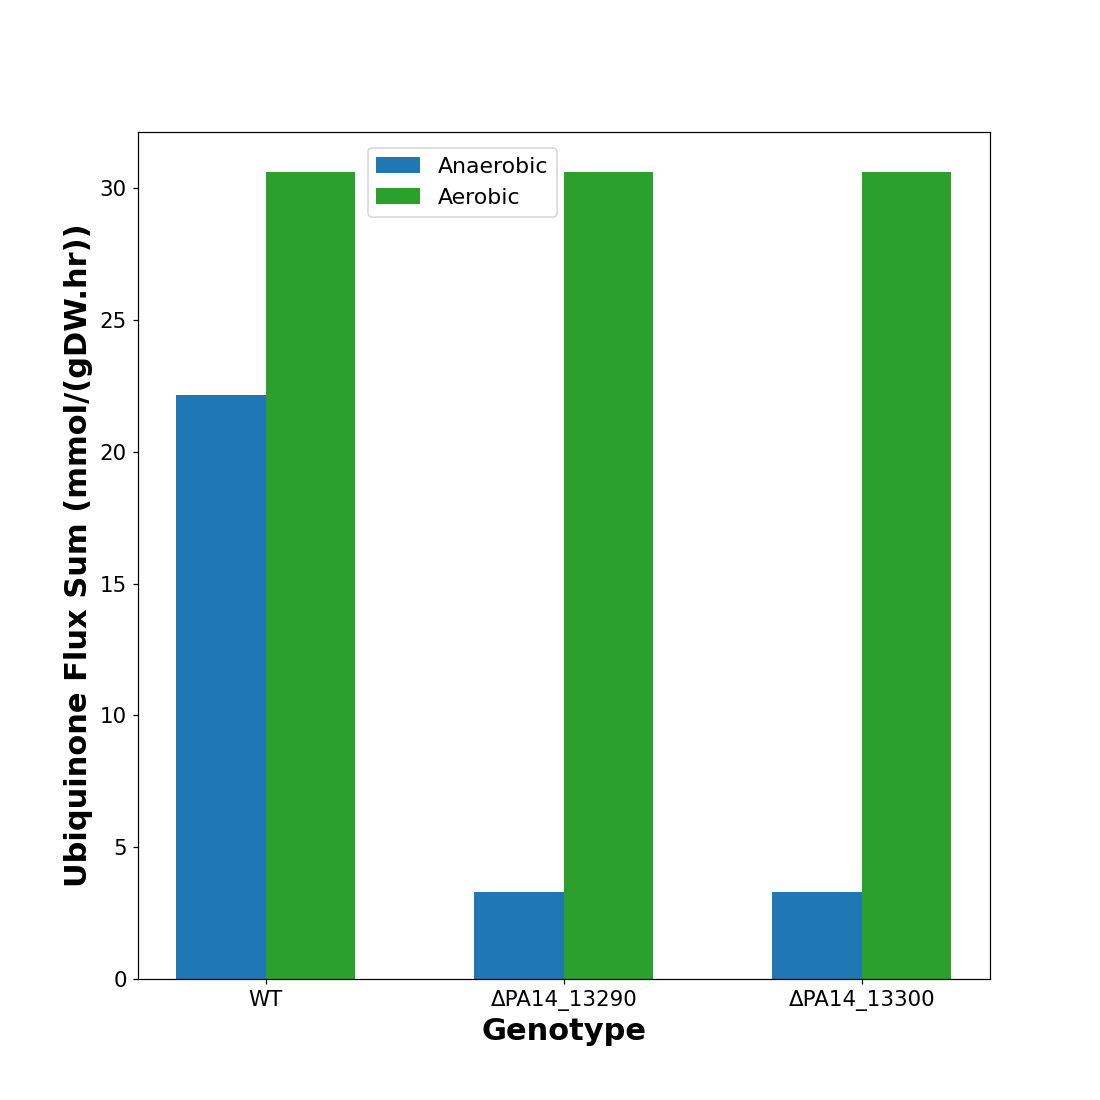

In [29]:
from matplotlib import pyplot as plt

# plotting
%matplotlib notebook

fig, ax1 = plt.subplots(figsize=(10, 10))
x = np.arange(3)
w = 0.3 #for additional space

plt.xticks(x + w/2, labels=condition_to_gr_uqProd_df.index, fontsize = 14)
ax1.set_xlabel('Genotype', fontsize = 20, fontweight='bold')
ax1.set_ylabel('Ubiquinone Flux Sum (mmol/(gDW.hr))', color='black', fontsize = 20, fontweight='bold')  # we already handled the x-label with ax1
ax1.bar(x, condition_to_gr_uqProd_df['no3'], label='Anaerobic', color='tab:blue', alpha = 1., width=w, align='center', visible=True)
ax1.bar(x+w, condition_to_gr_uqProd_df['o2'], label='Aerobic', color='tab:green', alpha = 1., width=w, align='center', visible=True)
ax1.tick_params(axis='y', labelcolor='black', labelsize = 14)

ax1.legend(loc=(0.27, 0.9), fontsize = 'x-large')

# if you want to save the figure, please uncomment the section below
# filename = join(mydir, '1_study_M-model/C2GrowthRate/anaerobic/')
# plt.savefig(join(filename, 'barplot_anaerobicGrowth_wtvmutants_uq9Prod.svg'), dpi = 300, transparent=True, orientation = 'portrait')

plt.show()